#Task 1: Acquire the data

info of dataset:
https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
print("TensorFlow GPU:", tf.config.list_physical_devices("GPU"))


TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#nomarlize
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

#split the default training partition into training and validation partitions.
val_size = 10000    #=test_size
train_size = 50000    #train-val
train_data, val_data = random_split(train_dataset, [train_size, val_size],generator=g)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]


In [ ]:
batch_size = 256  #defaut
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

#flatten
for images, labels in train_loader:
    print("Origin:", images.shape)
    images = images.view(images.size(0), -1)
    print("Flattened:", images.shape)
    break

Origin: torch.Size([256, 1, 28, 28])
Flattened: torch.Size([256, 784])


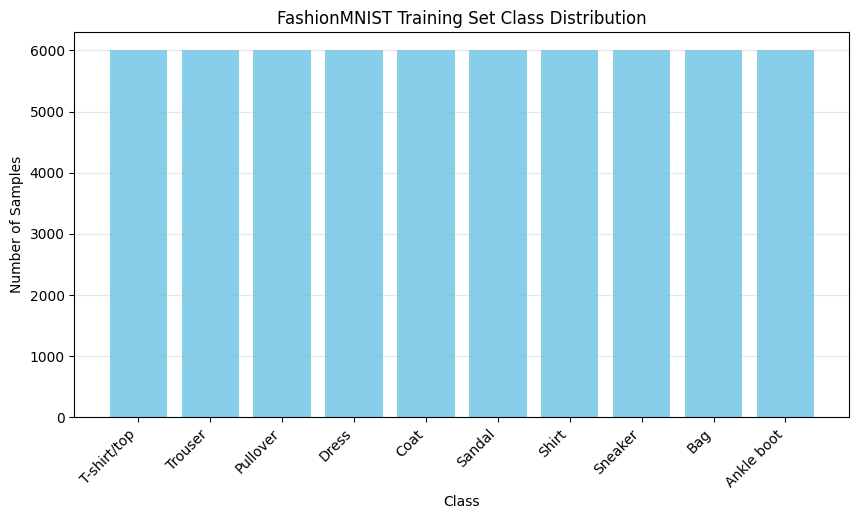

Counts: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [ ]:
# Understand data class distribution
from collections import Counter
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

labels = [label for _, label in train_dataset]
counter = Counter(labels)
counts = [counter[i] for i in range(10)]
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("FashionMNIST Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis="y", alpha=0.3)
plt.show()
print("Counts:", counter)

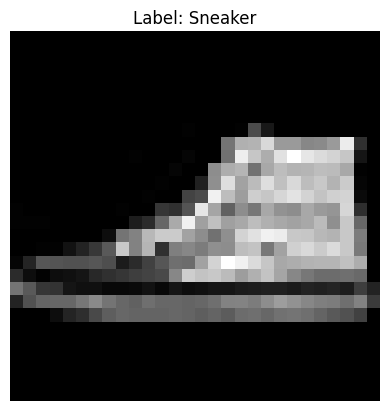

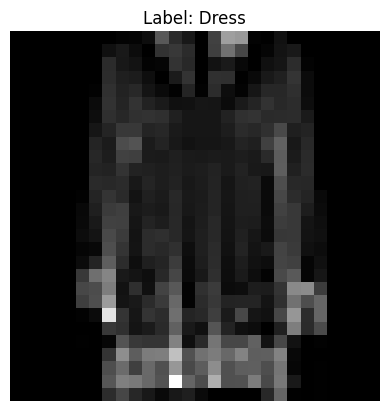

In [ ]:
# Visualize an Example
classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
images, labels = next(iter(train_loader))
for i in [0, 1]:
    img = torch.clamp(images[i] * 0.5 + 0.5, 0.0, 1.0).squeeze(0)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {classes[int(labels[i])]}")
    plt.axis('off')
    plt.show()


#Task 2: Implement a Multilayer Perceptron

In [ ]:
# Helper Funcitons
def one_hot(y, C):
    y = np.asarray(y, int).ravel()
    Y = np.zeros((y.size, C), float)
    Y[np.arange(y.size), y] = 1.0
    return Y

def softmax(x):
    max = np.max(x, axis=1, keepdims=True)
    e = np.exp(x - max)
    return e / np.sum(e, axis=1, keepdims=True)

def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
def sigmoid_grad(z): return z * (1.0 - z)
def relu(x): return np.maximum(0.0, x)
def relu_grad(z): return (z > 0).astype(z.dtype)
def tanh(x): return np.tanh(x)
def tanh_grad(z): return 1.0 - z**2
def leaky_relu(x):         return np.where(x > 0, x, 0.05 * x)
def leaky_relu_grad(z):    return np.where(z > 0, 1.0, 0.05).astype(z.dtype)

Activations = {
    "relu":    (relu, relu_grad),
    "sigmoid": (sigmoid, sigmoid_grad),
    "tanh":    (tanh, tanh_grad),
    "leakyrelu":  (leaky_relu, leaky_relu_grad),
    }


In [ ]:
import numpy as np

class MLP:
    def __init__(self, activation, h1=256, h2=256, n_hidden=2, seed=0, l1=0, l2=0):
        self.activation_name = str(activation).lower()
        self.act, self.act_grad = Activations[self.activation_name]
        self.h1 = int(h1)
        self.h2 = int(h2)
        self.n_hidden = int(n_hidden)  # choose 0, 1, or 2
        self.rng = np.random.default_rng(seed)
        self.l1 = float(l1)  # 0 means no l1 reg
        self.l2 = float(l2)  # 0 means no l2 reg
        self.W1 = self.b1 = None
        self.W2 = self.b2 = None
        self.W3 = self.b3 = None
        self.input_dim_ = None
        self.num_classes_ = None

    # Random initialize weights
    def _init_params(self, D, C):
        std = 0.065
        if self.n_hidden == 0:
            # X -> (W3,b3) -> softmax
            self.W3 = self.rng.normal(0.0, std, size=(D, C))
            self.b3 = np.zeros((C,), float)
        elif self.n_hidden == 1:
            # X -> (W1,b1) -> act -> (W3,b3) -> softmax
            self.W1 = self.rng.normal(0.0, std, size=(D, self.h1))
            self.b1 = np.zeros((self.h1,), float)
            self.W3 = self.rng.normal(0.0, std, size=(self.h1, C))
            self.b3 = np.zeros((C,), float)
        else:
            # X -> (W1,b1)-> act -> (W2,b2) -> act -> (W3,b3) -> softmax
            self.W1 = self.rng.normal(0.0, std, size=(D, self.h1));  self.b1 = np.zeros((self.h1,), float)
            self.W2 = self.rng.normal(0.0, std, size=(self.h1, self.h2)); self.b2 = np.zeros((self.h2,), float)
            self.W3 = self.rng.normal(0.0, std, size=(self.h2, C));  self.b3 = np.zeros((C,), float)

    # forward pass
    def _forward(self, X):
        if self.n_hidden == 0:
            U = X @ self.W3 + self.b3
            Umax = np.max(U, axis=1, keepdims=True)
            E = np.exp(U - Umax)
            Yhat = E / np.sum(E, axis=1, keepdims=True)
            cache = {"A0": X, "U": U, "Yhat": Yhat}
            return Yhat, cache

        elif self.n_hidden == 1:
            A0 = X
            Q1 = A0 @ self.W1 + self.b1
            Z1 = self.act(Q1)
            U  = Z1 @ self.W3 + self.b3
            Umax = np.max(U, axis=1, keepdims=True)
            E = np.exp(U - Umax)
            Yhat = E / np.sum(E, axis=1, keepdims=True)
            cache = {"A0": A0, "Q1": Q1, "Z1": Z1, "U": U, "Yhat": Yhat}
            return Yhat, cache

        else:
            A0 = X
            Q1 = A0 @ self.W1 + self.b1
            Z1 = self.act(Q1)
            Q2 = Z1 @ self.W2 + self.b2
            Z2 = self.act(Q2)
            U  = Z2 @ self.W3 + self.b3
            Umax = np.max(U, axis=1, keepdims=True)
            E = np.exp(U - Umax)
            Yhat = E / np.sum(E, axis=1, keepdims=True)
            cache = {"A0": A0, "Q1": Q1, "Z1": Z1, "Q2": Q2, "Z2": Z2, "U": U, "Yhat": Yhat}
            return Yhat, cache

    # loss and backprop
    def loss_and_grads(self, X, Y):
        N = X.shape[0]
        Yhat, c = self._forward(X)

        # cross-entropy
        eps = 1e-12
        loss = -np.mean(np.sum(Y * np.log(Yhat + eps), axis=1))

        # L1/L2 regularization
        if self.n_hidden == 0:
            if self.l2 > 0.0: loss += 0.5 * self.l2 * np.sum(self.W3**2)
            if self.l1 > 0.0: loss += self.l1 * np.sum(np.abs(self.W3))
        elif self.n_hidden == 1:
            if self.l2 > 0.0: loss += 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W3**2))
            if self.l1 > 0.0: loss += self.l1 * (np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W3)))
        else:
            if self.l2 > 0.0: loss += 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2))
            if self.l1 > 0.0: loss += self.l1 * (np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W2)) + np.sum(np.abs(self.W3)))

        # gradients
        dU = (c["Yhat"] - Y) / N

        if self.n_hidden == 0:
            gW3 = X.T @ dU
            gb3 = np.sum(dU, axis=0)
            if self.l2 > 0.0: gW3 += self.l2 * self.W3
            if self.l1 > 0.0: gW3 += self.l1 * np.sign(self.W3)
            return loss, (None, None, None, None, gW3, gb3)

        elif self.n_hidden == 1:
            gW3 = c["Z1"].T @ dU
            gb3 = np.sum(dU, axis=0)

            dZ1 = dU @ self.W3.T
            dQ1 = dZ1 * self.act_grad(c["Z1"])
            gW1 = c["A0"].T @ dQ1
            gb1 = np.sum(dQ1, axis=0)

            if self.l2 > 0.0:
                gW1 += self.l2 * self.W1
                gW3 += self.l2 * self.W3
            if self.l1 > 0.0:
                gW1 += self.l1 * np.sign(self.W1)
                gW3 += self.l1 * np.sign(self.W3)

            return loss, (gW1, gb1, None, None, gW3, gb3)

        else:
            gW3 = c["Z2"].T @ dU
            gb3 = np.sum(dU, axis=0)

            dZ2 = dU @ self.W3.T
            dQ2 = dZ2 * self.act_grad(c["Z2"])
            gW2 = c["Z1"].T @ dQ2
            gb2 = np.sum(dQ2, axis=0)

            dZ1 = dQ2 @ self.W2.T
            dQ1 = dZ1 * self.act_grad(c["Z1"])
            gW1 = c["A0"].T @ dQ1
            gb1 = np.sum(dQ1, axis=0)

            if self.l2 > 0.0:
                gW1 += self.l2 * self.W1
                gW2 += self.l2 * self.W2
                gW3 += self.l2 * self.W3
            if self.l1 > 0.0:
                gW1 += self.l1 * np.sign(self.W1)
                gW2 += self.l1 * np.sign(self.W2)
                gW3 += self.l1 * np.sign(self.W3)

            return loss, (gW1, gb1, gW2, gb2, gW3, gb3)

    # training
    def fit(self, X, y, lr=0.01, iters=30, batch_size=None, early_stopping=False,
            verbose=False, patience=5, tol=1e-4, X_val=None, y_val=None):
        X = np.asarray(X, float)
        y = np.asarray(y, int).ravel()
        N, D = X.shape
        C = int(y.max()) + 1

        if self.input_dim_ is None:
            self._init_params(D, C)
            self.input_dim_ = D
            self.num_classes_ = C

        # one-hot
        Y_full = np.zeros((N, C), float)
        Y_full[np.arange(N), y] = 1.0

        # batch size
        if batch_size is None or batch_size >= N:
            batch_size = N

        best_loss = float("inf")
        epochs_no_improve = 0
        self.train_acc_history = []
        self.val_acc_history = []

        log_every = max(1, iters // 10)
        for epoch in range(1, iters + 1):
            idx = self.rng.permutation(N)
            for s in range(0, N, batch_size):
                b = idx[s:s + batch_size]
                Xb, Yb = X[b], Y_full[b]

                loss, (gW1, gb1, gW2, gb2, gW3, gb3) = self.loss_and_grads(Xb, Yb)

                if self.n_hidden >= 1:
                    self.W1 -= lr * gW1; self.b1 -= lr * gb1
                if self.n_hidden == 2:
                    self.W2 -= lr * gW2; self.b2 -= lr * gb2
                self.W3 -= lr * gW3; self.b3 -= lr * gb3
                last_loss = loss

            train_pred = self.predict(X)
            train_acc = evaluate_acc(y, train_pred)
            self.train_acc_history.append(train_acc)

            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_acc = evaluate_acc(y_val, val_pred)
                self.val_acc_history.append(val_acc)
            else:
                self.val_acc_history_.append(None)

            if early_stopping:
                if last_loss + tol < best_loss:
                    best_loss = last_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        if verbose:
                            print(f"Early stop at epoch {epoch} | best loss {best_loss:.4f}")
                        return self

            if verbose and (epoch % log_every == 0 or epoch == 1 or epoch == iters):
                print(f"epoch {epoch:5d} | loss {loss:.4f}")

        return self

    def probability(self, X):
        X = np.asarray(X, float)
        Yhat, _ = self._forward(X)
        return Yhat

    def predict(self, X):
        return np.argmax(self.probability(X), axis=1)

In [ ]:
def evaluate_acc(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred).ravel()

    if y_true.ndim == 2:
        y_true = y_true.argmax(axis=1)
    else:
        y_true = y_true.ravel()

    return float((y_true == y_pred).mean())

#Task 3: Run the experiments and report

In [ ]:
# Prepare train, test, validation set
def to_numpy(dataloader):
    Xs, ys = [], []
    for xb, yb in dataloader:
        Xs.append(xb.view(xb.size(0), -1).numpy())
        ys.append(yb.numpy())
    return np.concatenate(Xs, 0), np.concatenate(ys, 0)

X_train, y_train = to_numpy(train_loader)
X_val, y_val = to_numpy(val_loader)
X_test, y_test = to_numpy(test_loader)

print(X_train.shape, y_train.shape)
print(X_val.shape,   y_val.shape)
print(X_test.shape,  y_test.shape)

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


In [ ]:
# no hidden layers, hyperparameter selection
# LR selection
import time
activation = "relu"
n_hidden = 0
l1 = 0.0
l2 = 0.0

lr_list = [0.001, 0.005, 0.01, 0.05, 0.1]
lr_results = []
for lr in lr_list:
    model = MLP(activation=activation, n_hidden=n_hidden, l1=l1, l2=l2, seed=0)
    t0 = time.perf_counter()
    model.fit(X_train, y_train, lr=lr, iters=10, batch_size=256, verbose=False, X_val=X_test, y_val=y_test)
    secs = time.perf_counter() - t0
    pred = model.predict(X_test)
    acc = evaluate_acc(y_test, pred)
    lr_results.append((lr, acc, secs))
    print(f"[lr] lr={lr:<8g} | Test acc={acc:.4f} | time={secs:.2f}s")
best_lr, best_lr_acc, best_lr_secs = max(lr_results, key=lambda t: t[1])
print(f"---> Best LR: {best_lr} | Test acc={best_lr_acc:.4f} | time={best_lr_secs:.2f}s")


[lr] lr=0.001    | Test acc=0.7348 | time=8.58s
[lr] lr=0.005    | Test acc=0.7958 | time=4.33s
[lr] lr=0.01     | Test acc=0.8141 | time=6.25s
[lr] lr=0.05     | Test acc=0.8299 | time=4.36s
[lr] lr=0.1      | Test acc=0.8204 | time=4.79s
---> Best LR: 0.05 | Test acc=0.8299 | time=4.36s


In [ ]:
# batch size selection
activation = "relu"
n_hidden = 0
batch_list = [32, 64, 128, 256, 512]
bs_results = []
for batch in batch_list:
    model = MLP(activation=activation, n_hidden=n_hidden, l1=l1, l2=l2, seed=0)
    t0 = time.perf_counter()
    model.fit(X_train, y_train, lr=0.05, iters=10, batch_size=batch, verbose=False, X_val=X_test, y_val=y_test)
    secs = time.perf_counter() - t0
    pred = model.predict(X_test)
    acc = evaluate_acc(y_test, pred)
    bs_results.append((batch, acc, secs))
    print(f"[batch] size={batch:<4d} | Test acc={acc:.4f} | time={secs:.2f}s")
best_bs, best_bs_acc, best_bs_secs = max(bs_results, key=lambda t: t[1])
print(f"---> Best batch_size: {best_bs} | Test acc={best_bs_acc:.4f} | time={best_bs_secs:.2f}s")

[batch] size=32   | Test acc=0.8292 | time=5.43s
[batch] size=64   | Test acc=0.8266 | time=5.82s
[batch] size=128  | Test acc=0.8345 | time=4.73s
[batch] size=256  | Test acc=0.8299 | time=4.63s
[batch] size=512  | Test acc=0.8264 | time=5.46s
---> Best batch_size: 128 | Test acc=0.8345 | time=4.73s


In [ ]:
activation = "relu"
n_hidden = 0
epoch_list = [10, 20, 30, 40, 60]
ep_results = []
for epoch in epoch_list:
    model = MLP(activation=activation, n_hidden=n_hidden, l1=l1, l2=l2, seed=0)
    t0 = time.perf_counter()
    model.fit(X_train, y_train, lr=0.05, iters=epoch, batch_size=128, verbose=False, X_val=X_test, y_val=y_test)
    secs = time.perf_counter() - t0
    pred = model.predict(X_test)
    acc = evaluate_acc(y_test, pred)
    ep_results.append((epoch, acc, secs))
    print(f"[epochs] {epoch:<3d} | Test acc={acc:.4f} | time={secs:.2f}s")
best_ep, best_ep_acc, best_ep_secs = max(ep_results, key=lambda t: t[1])
print(f"---> Best epochs: {best_ep} | Test acc={best_ep_acc:.4f} | time={best_ep_secs:.2f}s")

[epochs] 10  | Test acc=0.8345 | time=7.49s
[epochs] 20  | Test acc=0.8382 | time=11.28s
[epochs] 30  | Test acc=0.8416 | time=15.80s
[epochs] 40  | Test acc=0.8381 | time=22.59s
[epochs] 60  | Test acc=0.8413 | time=31.41s
---> Best epochs: 30 | Test acc=0.8416 | time=15.80s


In [ ]:
# Train no hidden unit with selected hyperparameter
activation = "relu"
n_hidden = 0
l1 = 0.0
l2 = 0.0
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_nohidden = MLP(activation=activation, n_hidden=n_hidden, l1=l1, l2=l2, seed=0)
model_nohidden.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred = model_nohidden.predict(X_val)
y_test_pred = model_nohidden.predict(X_test)

val_acc_nohidden = evaluate_acc(y_val, y_val_pred)
test_acc_nohidden = evaluate_acc(y_test, y_test_pred)

print("No hidden layer")
print(f"Val  acc: {val_acc_nohidden:.4f}")
print(f"Test acc: {test_acc_nohidden:.4f}")

No hidden layer
Val  acc: 0.8430
Test acc: 0.8350


In [ ]:
# a single hidden layer
activation = "relu"
n_hidden = 1
h1 = 256
l1 = 0.0
l2 = 0.0
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_onehidden = MLP(activation=activation, n_hidden=n_hidden, h1=h1, l1=l1, l2=l2, seed=0)
model_onehidden.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred  = model_onehidden.predict(X_val)
y_test_pred = model_onehidden.predict(X_test)

val_acc_onehidden = evaluate_acc(y_val,  y_val_pred)
test_acc_onehidden = evaluate_acc(y_test, y_test_pred)

print("1 hidden layer")
print(f"Val  acc: {val_acc_onehidden:.4f}")
print(f"Test acc: {test_acc_onehidden:.4f}")

1 hidden layer
Val  acc: 0.8878
Test acc: 0.8785


In [ ]:
# 2 hidden layers
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0
l2 = 0.0
lr, iters, batch_size, verbose = 0.05, 20, 64, False

model_twohidden = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_twohidden.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred  = model_twohidden.predict(X_val)
y_test_pred = model_twohidden.predict(X_test)

val_acc_twohidden = evaluate_acc(y_val,  y_val_pred)
test_acc_twohidden = evaluate_acc(y_test, y_test_pred)

print("2 hidden layers")
print(f"Val  acc: {val_acc_twohidden:.4f}")
print(f"Test acc: {test_acc_twohidden:.4f}")

2 hidden layers
Val  acc: 0.8750
Test acc: 0.8690


Non-linearity significantly boosts performance, best performance achieved with 1 hidden layer, batch size 128, 30 epochs.

In [ ]:
# 2 hidden layers, tanh activation function
activation = "tanh"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0
l2 = 0.0
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_tanh = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_tanh.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred  = model_tanh.predict(X_val)
y_test_pred = model_tanh.predict(X_test)

val_acc_tanh = evaluate_acc(y_val,  y_val_pred)
test_acc_tanh = evaluate_acc(y_test, y_test_pred)

print("2 hidden layers - tanh")
print(f"Val  acc: {val_acc_tanh:.4f}")
print(f"Test acc: {test_acc_tanh:.4f}")

2 hidden layers - tanh
Val  acc: 0.8818
Test acc: 0.8791


In [ ]:
# 2 hidden layers, leaky-relu activation function
activation = "leakyrelu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0
l2 = 0.0
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_lrelu = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_lrelu.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred  = model_lrelu.predict(X_val)
y_test_pred = model_lrelu.predict(X_test)

val_acc_lrelu  = evaluate_acc(y_val,  y_val_pred)
test_acc_lrelu = evaluate_acc(y_test, y_test_pred)

print("2 hidden layers - leaky-relu")
print(f"Val  acc: {val_acc_lrelu:.4f}")
print(f"Test acc: {test_acc_lrelu:.4f}")

2 hidden layers - leaky-relu
Val  acc: 0.8805
Test acc: 0.8743


tanh performed best with 0.8791 accuracy, likely due to smoother gradients helping optimization. Leaky-ReLU helps avoid dead neurons but didn’t outperform tanh here, performance differences are small.

In [ ]:
# Tune l1 and l2 value
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
lr, iters, batch_size, verbose = 0.05, 30, 128, False

# l2
l2_list = [1e-4, 3e-4, 1e-3, 3e-3]
l2_results = []
for l2 in l2_list:
    model = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=0, l2=l2, seed=0)
    model.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)
    pred = model.predict(X_test)
    acc = evaluate_acc(y_test, pred)
    l2_results.append((l2, acc))
    print(f"[L2 only] λ2={l2:<8.1g} | Test acc = {acc:.4f}")
best_l2, best_l2_acc = max(l2_results, key=lambda t: t[1])
print(f"--> Best L2: λ2={best_l2} | Test acc = {best_l2_acc:.4f}")

#l1
l1_list = [1e-4, 3e-4, 1e-3, 3e-3]
l1_results = []
for l1 in l1_list:
    model = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=0, seed=0)
    model.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)
    pred = model.predict(X_test)
    acc = evaluate_acc(y_test, pred)
    l1_results.append((l1, acc))
    print(f"[L1 only] λ1={l1:<8.1g} | Test acc = {acc:.4f}")

best_l1, best_l1_acc = max(l1_results, key=lambda t: t[1])
print(f"--> Best L1: λ1={best_l1} | Test acc = {best_l1_acc:.4f}")

[L2 only] λ2=0.0001   | Test acc = 0.8814
[L2 only] λ2=0.0003   | Test acc = 0.8803
[L2 only] λ2=0.001    | Test acc = 0.8798
[L2 only] λ2=0.003    | Test acc = 0.8735
--> Best L2: λ2=0.0001 | Test acc = 0.8814
[L1 only] λ1=0.0001   | Test acc = 0.8744
[L1 only] λ1=0.0003   | Test acc = 0.8538
[L1 only] λ1=0.001    | Test acc = 0.8327
[L1 only] λ1=0.003    | Test acc = 0.7895
--> Best L1: λ1=0.0001 | Test acc = 0.8744


In [ ]:
# Model with best L2
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0
l2 = 0.0001
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_bestl2 = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_bestl2.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose,X_val=X_test, y_val=y_test)

y_val_pred  = model_bestl2.predict(X_val)
y_test_pred = model_bestl2.predict(X_test)

val_acc_bestl2  = evaluate_acc(y_val,  y_val_pred)
test_acc_bestl2 = evaluate_acc(y_test, y_test_pred)

print("2 hidden layers - Best L2")
print(f"Val  acc: {val_acc_bestl2:.4f}")
print(f"Test acc: {test_acc_bestl2:.4f}")

2 hidden layers - Best L2
Val  acc: 0.8831
Test acc: 0.8794


In [ ]:
# Model with best L1
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0001
l2 = 0
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_bestl1 = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_bestl1.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose,X_val=X_test, y_val=y_test)

y_val_pred = model_bestl1.predict(X_val)
y_test_pred = model_bestl1.predict(X_test)

val_acc_bestl1 = evaluate_acc(y_val,  y_val_pred)
test_acc_bestl1 = evaluate_acc(y_test, y_test_pred)

print("2 hidden layers - Best L1")
print(f"Val  acc: {val_acc_bestl1:.4f}")
print(f"Test acc: {test_acc_bestl1:.4f}")

2 hidden layers - Best L1
Val  acc: 0.8768
Test acc: 0.8745


In [ ]:
# Train a model with best l1 and best l2
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0001
l2 = 0.0001
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_bestl1l2 = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_bestl1l2.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose,X_val=X_test, y_val=y_test)

y_val_pred  = model_bestl1l2.predict(X_val)
y_test_pred = model_bestl1l2.predict(X_test)

val_acc_bestl1l2  = evaluate_acc(y_val,  y_val_pred)
test_acc_bestl1l2 = evaluate_acc(y_test, y_test_pred)

print("2 hidden layers - Best L1&L2")
print(f"Val  acc: {val_acc_bestl1l2:.4f}")
print(f"Test acc: {test_acc_bestl1l2:.4f}")

2 hidden layers - Best L1&L2
Val  acc: 0.8775
Test acc: 0.8764


L2 slightly improves generalization, giving the highest accuracy of 0.8794, L1 tends to sparsify weights but can reduce performance if too strong, too high λ reduces accuracy.

In [ ]:
# Get raw data
SEED = 0
torch.manual_seed(SEED)
g = torch.Generator().manual_seed(SEED)
raw_transform = transforms.ToTensor()
train_ds_raw = datasets.FashionMNIST(root='./data', train=True,  download=True, transform=raw_transform)
test_ds_raw  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=raw_transform)
val_size = 10000
train_size = 50000
train_data_raw, val_data_raw = random_split(train_ds_raw, [train_size, val_size],generator=g)
batch_size = 256

train_loader_raw = DataLoader(train_data_raw, batch_size=batch_size, shuffle=True)
val_loader_raw = DataLoader(val_data_raw, batch_size, shuffle=False)
test_loader_raw = DataLoader(test_ds_raw, batch_size, shuffle=False)

X_train_raw, y_train_raw = to_numpy(train_loader_raw)
X_val_raw, y_val_raw = to_numpy(val_loader_raw)
X_test_raw, y_test_raw = to_numpy(test_loader_raw)

print(X_train_raw.shape, X_val_raw.shape, X_test_raw.shape)


(50000, 784) (10000, 784) (10000, 784)


In [ ]:
# Train with un-normalized data
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0001
l2 = 0.0001
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_nonorm = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_nonorm.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred = model_nonorm.predict(X_val_raw)
y_test_pred = model_nonorm.predict(X_test_raw)

val_acc_nonorm  = evaluate_acc(y_val_raw,  y_val_pred)
test_acc_nonorm = evaluate_acc(y_test_raw, y_test_pred)

print("2 hidden layers - unnormalized data")
print(f"Val  acc: {val_acc_nonorm:.4f}")
print(f"Test acc: {test_acc_nonorm:.4f}")

2 hidden layers - unnormalized data
Val  acc: 0.7401
Test acc: 0.7379


Unnormalized data: Test acc = 0.7379, much lower than the normalized model (~0.87–0.88), so normalization is essential for stable training by improving accuracy dramatically

In [ ]:
# Augment data (light transform)
SEED = 0
torch.manual_seed(SEED)
g = torch.Generator().manual_seed(SEED)
train_aug_light = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_aug_ds = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=train_aug_light)
test_ds_aug = datasets.FashionMNIST(root="./data", train=False, download=True, transform=test_transform)
val_size = 10000
train_size = 50000
train_ds_aug, val_ds_aug = random_split(train_aug_ds, [train_size, val_size],generator=g)
batch_size = 256

val_ds_aug.dataset.transform = test_transform

train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_ds_aug, batch_size, shuffle=False)
test_loader_aug = DataLoader(test_ds_aug, batch_size, shuffle=False)

X_train_aug, y_train_aug = to_numpy(train_loader_aug)
X_val_aug, y_val_aug = to_numpy(val_loader_aug)
X_test_aug, y_test_aug = to_numpy(test_loader_aug)

print("shapes:", X_train_aug.shape, X_val_aug.shape, X_test_aug.shape)


shapes: (50000, 784) (10000, 784) (10000, 784)


In [ ]:
# Train on light transformed data
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0001
l2 = 0.0001
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_lighttrans = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_lighttrans.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred = model_lighttrans.predict(X_val_aug)
y_test_pred = model_lighttrans.predict(X_test_aug)

val_acc_lighttrans = evaluate_acc(y_val_aug,  y_val_pred)
test_acc_lighttrans = evaluate_acc(y_test_aug, y_test_pred)

print("2 hidden layers - light augmented data")
print(f"Val  acc: {val_acc_lighttrans:.4f}")
print(f"Test acc: {test_acc_lighttrans:.4f}")


2 hidden layers - light augmented data
Val  acc: 0.8775
Test acc: 0.8764


In [ ]:
# Augment data (heavy transform)
train_aug_heavy = transforms.Compose([
    transforms.RandomAffine(degrees=12, translate=(0.06, 0.06), scale=(0.92, 1.08), shear=6),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_aug_ds2 = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=train_aug_heavy)
test_ds_aug2 = datasets.FashionMNIST(root="./data", train=False, download=True, transform=test_transform)
val_size = 10000
train_size = 50000
train_ds_aug2, val_ds_aug2 = random_split(train_aug_ds2, [train_size, val_size],generator=g)
batch_size = 256

val_ds_aug2.dataset.transform = test_transform

train_loader_aug2 = DataLoader(train_ds_aug2, batch_size=batch_size, shuffle=True)
val_loader_aug2 = DataLoader(val_ds_aug2, batch_size, shuffle=False)
test_loader_aug2 = DataLoader(test_ds_aug2, batch_size, shuffle=False)

X_train_aug2, y_train_aug2 = to_numpy(train_loader_aug2)
X_val_aug2, y_val_aug2 = to_numpy(val_loader_aug2)
X_test_aug2, y_test_aug2 = to_numpy(test_loader_aug2)

print("shapes:", X_train_aug2.shape, X_val_aug2.shape, X_test_aug2.shape)

shapes: (50000, 784) (10000, 784) (10000, 784)


In [ ]:
# Train on heavy transformed data
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0.0001
l2 = 0.0001
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_heavytrans = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_heavytrans.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred = model_heavytrans.predict(X_val_aug2)
y_test_pred = model_heavytrans.predict(X_test_aug2)

val_acc_heavytrans  = evaluate_acc(y_val_aug2,  y_val_pred)
test_acc_heavytrans = evaluate_acc(y_test_aug2, y_test_pred)

print("2 hidden layers - heavy augmented data")
print(f"Val  acc: {val_acc_heavytrans:.4f}")
print(f"Test acc: {test_acc_heavytrans:.4f}")

2 hidden layers - heavy augmented data
Val  acc: 0.9056
Test acc: 0.8764


Heavy augmentation strongly improves validation accuracy (0.9056), but test accuracy does not increase because the MLP is limited in capacity and cannot fully exploit the augmented diversity.

In [ ]:
# Best Model is MLP with l2 reg, we want to see if early stopping will increase the accuracy of this model
activation = "relu"
n_hidden = 2
h1, h2 = 256, 256
l1 = 0
l2 = 0.0001
lr, iters, batch_size, verbose = 0.05, 30, 128, False

model_early = MLP(activation=activation, n_hidden=n_hidden, h1=h1, h2=h2, l1=l1, l2=l2, seed=0)
model_early.fit(X_train, y_train, lr=lr, iters=iters, batch_size=batch_size, early_stopping=True,
                     verbose=verbose, X_val=X_test, y_val=y_test)

y_val_pred = model_early.predict(X_val_aug2)
y_test_pred = model_early.predict(X_test_aug2)

val_acc_early = evaluate_acc(y_val_aug2, y_val_pred)
test_acc_early = evaluate_acc(y_test_aug2, y_test_pred)

print("2 hidden layers - L2 Reg with Early Stopping")
print(f"Val  acc: {val_acc_early:.4f}")
print(f"Test acc: {test_acc_early:.4f}")

2 hidden layers - L2 Reg with Early Stopping
Val  acc: 0.9247
Test acc: 0.8806


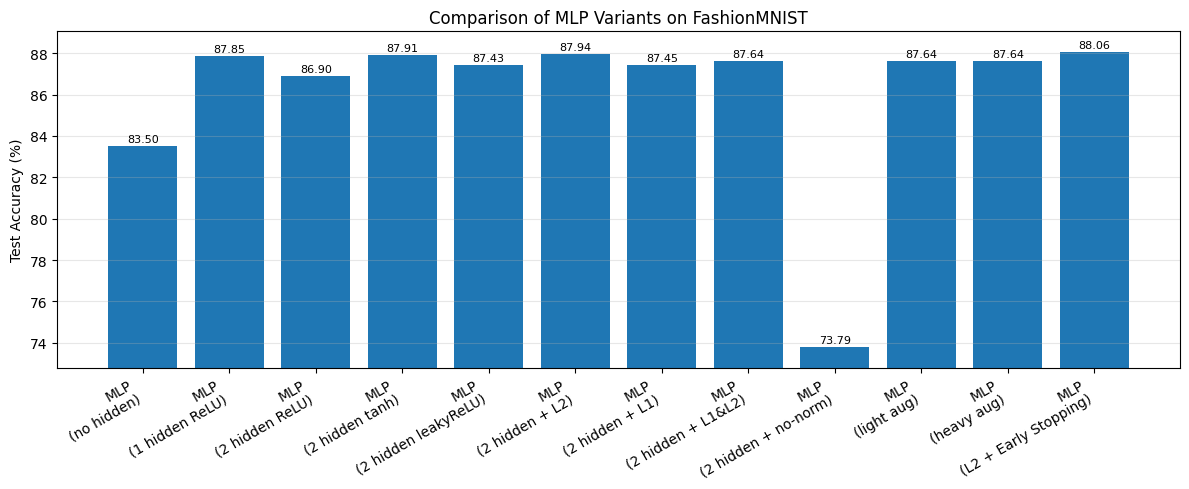

In [ ]:
# Final plot comparing all MLP Models Implemented
names = ["MLP\n(no hidden)", "MLP\n(1 hidden ReLU)","MLP\n(2 hidden ReLU)","MLP\n(2 hidden tanh)",
        "MLP\n(2 hidden leakyReLU)","MLP\n(2 hidden + L2)","MLP\n(2 hidden + L1)",
        "MLP\n(2 hidden + L1&L2)","MLP\n(2 hidden + no-norm)","MLP\n(light aug)","MLP\n(heavy aug)", "MLP\n(L2 + Early Stopping)"]

accs = [test_acc_nohidden,test_acc_onehidden,test_acc_twohidden,test_acc_tanh,test_acc_lrelu,
        test_acc_bestl2,test_acc_bestl1,test_acc_bestl1l2,test_acc_nonorm, test_acc_lighttrans,
        test_acc_heavytrans,test_acc_early]

accs_pct = [a * 100 for a in accs]

x = np.arange(len(names))
plt.figure(figsize=(12, 5))
bars = plt.bar(x, accs_pct)
plt.xticks(x, names, rotation=30, ha="right")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of MLP Variants on FashionMNIST")
plt.ylim(min(accs_pct) - 1, max(accs_pct) + 1)
plt.grid(axis="y", alpha=0.3)
for bar, acc in zip(bars, accs_pct):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.1,
             f"{acc:.2f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()


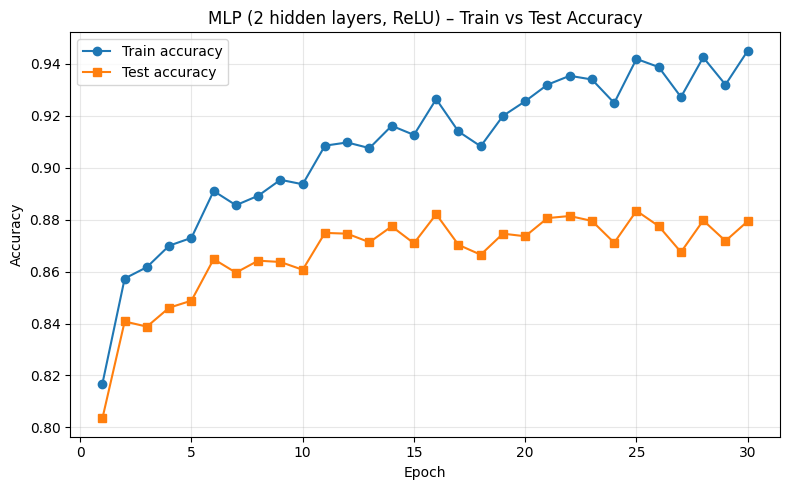

In [ ]:
# Train vs Test Accuracy Plot for epochs using Our Best MLP Model (Two hidden layer Relu + L2)
epochs = np.arange(1, len(model_bestl2.train_acc_history) + 1)
train_acc = model_bestl2.train_acc_history
test_acc  = model_bestl2.val_acc_history

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, marker="o", label="Train accuracy")
plt.plot(epochs, test_acc,  marker="s", label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP (2 hidden layers, ReLU) – Train vs Test Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Result: 2 hidden layer with L2 regularization has the best performance

In [ ]:
import tensorflow as tf
tf.random.set_seed(0)
def reshape(x):
    x = np.asarray(x)
    if x.ndim == 2 and x.shape[1] == 784:
        x = x.reshape(-1, 28, 28, 1)
    elif x.ndim == 3 and x.shape[1:] == (28, 28):
        x = x[..., None]
    return x.astype(np.float32)

def fix_scale(x):
    x = np.asarray(x).astype("float32")
    lo, hi = float(x.min()), float(x.max())
    if hi > 2.5:
        return x / 255.0
    if lo < -0.5 and hi <= 1.0:
        return (x + 1.0) / 2.0
    return x

X_train = reshape(X_train)
X_val = reshape(X_val)
X_test = reshape(X_test)
X_train = fix_scale(X_train)
X_val = fix_scale(X_val)
X_test = fix_scale(X_test)
y_train = np.asarray(y_train).astype(np.int64)
y_val = np.asarray(y_val).astype(np.int64)
y_test = np.asarray(y_test).astype(np.int64)

print("X_train:", X_train.shape, X_train.dtype, (X_train.min(), X_train.max()))
print("y_train:", y_train.shape, y_train.dtype, "unique:", np.unique(y_train)[:10])

X_train: (50000, 28, 28, 1) float32 (np.float32(0.0), np.float32(1.0))
y_train: (50000,) int64 unique: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# CNN setup for training and hyperparameter tuning
tf.random.set_seed(0)

def build_cnn(filters1=32, filters2=64, kernel_size=3, pool_type="max",lr=1e-3):
    Pool = tf.keras.layers.MaxPool2D if pool_type == "max" else tf.keras.layers.AveragePooling2D
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(filters1, kernel_size, padding="same",activation="relu")(inputs)
    x = Pool(2)(x)
    x = tf.keras.layers.Conv2D(filters2, kernel_size, padding="same", activation="relu")(x)
    x = Pool(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name="cnn")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    return model


def train_cnn(lr=1e-3, batch_size=256, epochs=15, filters1=32, filters2=64, kernel_size=3, pool_type="max", use_callbacks=True):
    model = build_cnn(filters1=filters1, filters2=filters2, kernel_size=kernel_size, pool_type=pool_type, lr=lr)
    callbacks = []
    if use_callbacks:
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4,restore_best_weights=True, verbose=0),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,patience=2, verbose=0),
        ]
    t0 = time.time()
    history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=epochs,batch_size=batch_size,callbacks=callbacks,verbose=0,)
    secs = time.time() - t0
    best_val_acc = float(np.max(history.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    return best_val_acc, float(test_acc), secs

In [ ]:
# Tune learning rate
lr_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
batch_size = 256
epochs = 3
lr_results = []
for lr in lr_list:
    val_acc, test_acc, secs = train_cnn(lr=lr, batch_size=batch_size, epochs=epochs)
    lr_results.append((lr, val_acc, test_acc, secs))
    print(f"lr={lr:<6g} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")
best_lr, best_lr_val, best_lr_test, best_lr_secs = max(lr_results, key=lambda t: t[1])
print(f"\n--> Best lr={best_lr} | val_acc={best_lr_val:.4f} | test_acc={best_lr_test:.4f}")

lr=0.0001 | val_acc=0.8489 | test_acc=0.8449 | time=248.4s
lr=0.0005 | val_acc=0.8803 | test_acc=0.8748 | time=212.1s
lr=0.001  | val_acc=0.8910 | test_acc=0.8816 | time=208.3s
lr=0.005  | val_acc=0.9053 | test_acc=0.9008 | time=204.3s
lr=0.01   | val_acc=0.8980 | test_acc=0.8959 | time=247.1s

--> Best lr=0.005 | val_acc=0.9053 | test_acc=0.9008


In [ ]:
# Tune batch size
batch_list = [64, 128, 256, 512]
epochs = 3

bs_results = []
for bs in batch_list:
    val_acc, test_acc, secs = train_cnn(
        lr=0.005, batch_size=bs, epochs=epochs
    )
    bs_results.append((bs, val_acc, test_acc, secs))
    print(f"batch={bs:<4d} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")

best_bs, best_bs_val, best_bs_test, best_bs_secs = max(bs_results, key=lambda t: t[1])
print(f"\n--> Best batch_size={best_bs} | val_acc={best_bs_val:.4f} | test_acc={best_bs_test:.4f}")

batch=64   | val_acc=0.8968 | test_acc=0.8937 | time=196.4s
batch=128  | val_acc=0.9040 | test_acc=0.9003 | time=185.6s
batch=256  | val_acc=0.9006 | test_acc=0.8974 | time=206.6s
batch=512  | val_acc=0.9005 | test_acc=0.8950 | time=212.1s

--> Best batch_size=128 | val_acc=0.9040 | test_acc=0.9003


In [ ]:
# Tune filter size (how many channel)
filter_configs = [(16, 32), (32, 64), (64, 128)]
arch_results_f = []
for f1, f2 in filter_configs:
    val_acc, test_acc, secs = train_cnn(
        lr=best_lr, batch_size=best_bs, epochs=3,
        filters1=f1, filters2=f2
    )
    arch_results_f.append(((f1, f2), val_acc, test_acc, secs))
    print(f"filters=({f1},{f2}) | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")

(best_f1, best_f2), best_f_val, best_f_test, best_f_secs = max(arch_results_f, key=lambda t: t[1])
print(f"\n--> Best filters=({best_f1},{best_f2}) | val_acc={best_f_val:.4f} | test_acc={best_f_test:.4f}")

filters=(16,32) | val_acc=0.8952 | test_acc=0.8940 | time=117.4s
filters=(32,64) | val_acc=0.8943 | test_acc=0.8937 | time=221.7s
filters=(64,128) | val_acc=0.9033 | test_acc=0.8976 | time=505.6s

--> Best filters=(64,128) | val_acc=0.9033 | test_acc=0.8976


Filter size of (64,128) is chosen, achieving a test accuracy of 0.9008, which is higher than all MLP variants.

In [ ]:
# Tune Kernel size
kernel_list = [1, 3, 5]
arch_results_k = []
for ks in kernel_list:
    val_acc, test_acc, secs = train_cnn(
        lr=best_lr, batch_size=best_bs, epochs=3,
        filters1=16, filters2=32,
        kernel_size=ks
    )
    arch_results_k.append((ks, val_acc, test_acc, secs))
    print(f"kernel={ks}x{ks} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")

best_ks, best_k_val, best_k_test, best_k_secs = max(arch_results_k, key=lambda t: t[1])
print(f"\n--> Best kernel size={best_ks} | val_acc={best_k_val:.4f} | test_acc={best_k_test:.4f}")

kernel=1x1 | val_acc=0.8392 | test_acc=0.8323 | time=65.2s
kernel=3x3 | val_acc=0.8989 | test_acc=0.8953 | time=112.5s
kernel=5x5 | val_acc=0.8946 | test_acc=0.8900 | time=208.9s

--> Best kernel size=3 | val_acc=0.8989 | test_acc=0.8953


In [ ]:
# Tune pooling methods
pool_types = ["max", "avg"]
arch_results_p = []
for p in pool_types:
    val_acc, test_acc, secs = train_cnn(
        lr=best_lr, batch_size=best_bs, epochs=3,
        filters1=16, filters2=31,
        kernel_size=best_ks, pool_type=p
    )
    arch_results_p.append((p, val_acc, test_acc, secs))
    print(f"pool={p:<3} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")

best_pool, best_p_val, best_p_test, best_p_secs = max(arch_results_p, key=lambda t: t[1])
print(f"\n--> Best pooling={best_pool} | val_acc={best_p_val:.4f} | test_acc={best_p_test:.4f}")


pool=max | val_acc=0.9036 | test_acc=0.8958 | time=120.5s
pool=avg | val_acc=0.8934 | test_acc=0.8931 | time=100.5s

--> Best pooling=max | val_acc=0.9036 | test_acc=0.8958


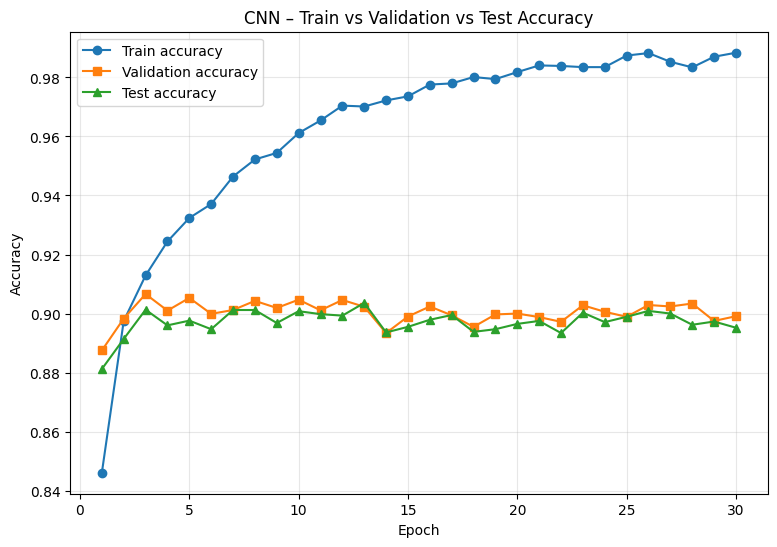

In [ ]:
# Train final CNN with selected hyperparameters
tf.random.set_seed(0)

best_lr = 0.005
best_batch = 128
epochs = 30
best_f1 = 16
best_f2 = 32
best_kernel = 3
best_pool = "max"
final_model = build_cnn(filters1=best_f1,filters2=best_f2,kernel_size=best_kernel,pool_type=best_pool,lr=best_lr,)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True,verbose=0,),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=2,verbose=0,),
    ]
t0 = time.time()

train_acc_hist = []
val_acc_hist = []
test_acc_hist = []
for epoch in range(epochs):
    hist = final_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=best_batch,
        callbacks=callbacks,
        verbose=0
    )
    train_acc_hist.append(hist.history["accuracy"][0])
    val_acc_hist.append(hist.history["val_accuracy"][0])
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    test_acc_hist.append(test_acc)


epochs_axis = np.arange(1, len(train_acc_hist) + 1)
plt.figure(figsize=(9, 6))
plt.plot(epochs_axis, train_acc_hist, marker="o", label="Train accuracy")
plt.plot(epochs_axis, val_acc_hist, marker="s", label="Validation accuracy")
plt.plot(epochs_axis, test_acc_hist, marker="^", label="Test accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN – Train vs Validation vs Test Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

total_secs_cnn = time.time() - t0
test_loss_cnn, test_acc_cnn = final_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print("\n-Final CNN Results-")
print(f"Test accuracy: {test_acc_cnn:.4f}")
print(f"Total training time: {total_secs_cnn:.2f} seconds (~{total_secs_cnn/60:.2f} min)")


-Final CNN Results-
Test accuracy: 0.8952
Total training time: 92.12 seconds (~1.54 min)


- CNN significantly outperforms every MLP variant, although training takes longer, the accuracy gain is substancial.
- With GPU it takes around 2 min and without GPU it takes around 20 min

In [ ]:
# CNN on small augmented data
tf.random.set_seed(0)
X_train_aug = fix_scale(reshape(X_train_aug))
X_val_aug = fix_scale(reshape(X_val_aug))
X_test_aug = fix_scale(reshape(X_test_aug))
y_train_aug = np.asarray(y_train_aug).astype(np.int64).ravel()
y_val_aug = np.asarray(y_val_aug).astype(np.int64).ravel()
y_test_aug = np.asarray(y_test_aug).astype(np.int64).ravel()

best_lr = 0.005
best_batch = 128
max_epochs = 30
best_f1 = 16
best_f2 = 32
best_kernel = 3
best_pool = "max"
final_model = build_cnn(filters1=best_f1,filters2=best_f2,kernel_size=best_kernel,pool_type=best_pool,lr=best_lr,)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True,verbose=1,),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=2,verbose=1,),
    ]
t0 = time.time()
history = final_model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val_aug, y_val_aug),
    epochs=max_epochs,
    batch_size=best_batch,
    verbose=0
)
total_secs_cnn_light = time.time() - t0
test_loss_cnn_light, test_acc_cnn_light = final_model.evaluate(X_test_aug, y_test_aug, verbose=0)

print("\n-Final CNN With Light Augmented Data Results-")
print(f"Test accuracy: {test_acc_cnn_light:.4f}")
print(f"Total training time: {total_secs_cnn_light:.2f} seconds (~{total_secs_cnn_light/60:.2f} min)")


-Final CNN With Light Augmented Data Results-
Test accuracy: 0.9026
Total training time: 53.31 seconds (~0.89 min)


In [ ]:
# CNN on heavy augmented data
tf.random.set_seed(0)
X_train_aug2 = fix_scale(reshape(X_train_aug2))
X_val_aug2 = fix_scale(reshape(X_val_aug2))
X_test_aug2 = fix_scale(reshape(X_test_aug2))
y_train_aug2 = np.asarray(y_train_aug2).astype(np.int64).ravel()
y_val_aug2 = np.asarray(y_val_aug2).astype(np.int64).ravel()
y_test_aug2 = np.asarray(y_test_aug2).astype(np.int64).ravel()

best_lr = 0.005
best_batch = 128
max_epochs = 30
best_f1 = 16
best_f2 = 32
best_kernel = 3
best_pool = "max"
final_model = build_cnn(filters1=best_f1,filters2=best_f2,kernel_size=best_kernel,pool_type=best_pool,lr=best_lr,)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True,verbose=1,),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=2,verbose=1,),
    ]
t0 = time.time()
history = final_model.fit(
    X_train_aug2, y_train_aug2,
    validation_data=(X_val_aug2, y_val_aug2),
    epochs=max_epochs,
    batch_size=best_batch,
    verbose=0
)
total_secs_cnn_heavy = time.time() - t0
test_loss_cnn_heavy, test_acc_cnn_heavy = final_model.evaluate(X_test_aug2, y_test_aug2, verbose=0)

print("\n-Final CNN With Heavy Augmented Data Results-")
print(f"Test accuracy: {test_acc_cnn_heavy:.4f}")
print(f"Total training time: {total_secs_cnn_heavy:.2f} seconds (~{total_secs_cnn_heavy/60:.2f} min)")


-Final CNN With Heavy Augmented Data Results-
Test accuracy: 0.9029
Total training time: 50.77 seconds (~0.85 min)


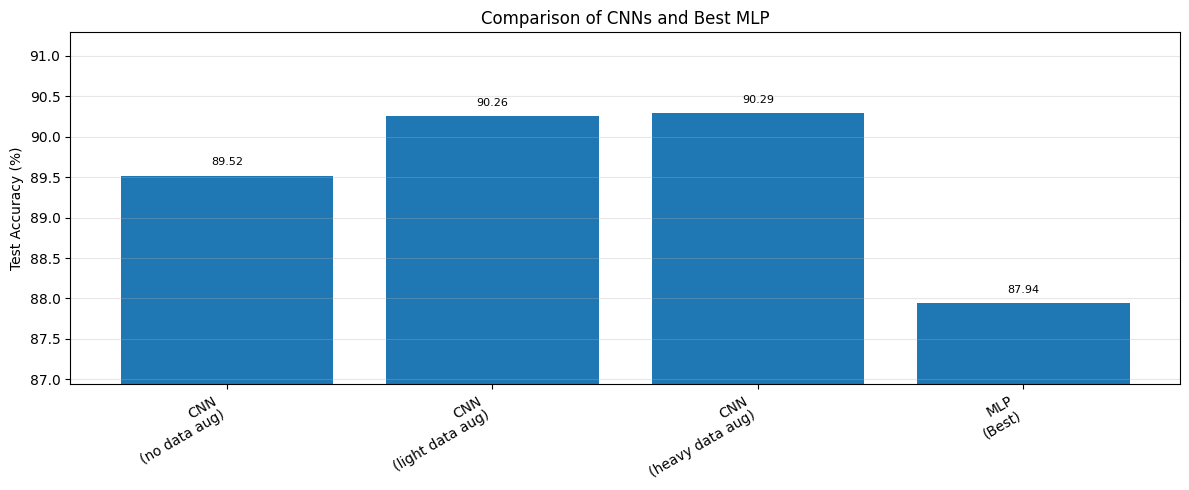

In [ ]:
# Final plot comparing all CNN Models Implemented
names = ["CNN\n(no data aug)","CNN\n(light data aug)","CNN\n(heavy data aug)","MLP\n(Best)",]
accs = [test_acc_cnn, test_acc_cnn_light,test_acc_cnn_heavy,test_acc_bestl2,]
accs_pct = [a * 100 for a in accs]
x = np.arange(len(names))
plt.figure(figsize=(12, 5))
bars = plt.bar(x, accs_pct)
plt.xticks(x, names, rotation=30, ha="right")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of CNNs and Best MLP")
plt.ylim(min(accs_pct) - 1, max(accs_pct) + 1)
plt.grid(axis="y", alpha=0.3)
for bar, acc in zip(bars, accs_pct):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.1,
             f"{acc:.2f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

Unlike MLPs, CNNs benefit significantly from data augmentation, light augmentation improves accuracy to the best result of 0.9043.

In [ ]:
# Process data to three channel
tf.random.set_seed(0)
X_train_aug = fix_scale(reshape(X_train_aug))
X_val_aug = fix_scale(reshape(X_val_aug))
X_test_aug = fix_scale(reshape(X_test_aug))
y_train_aug = np.asarray(y_train_aug).astype(np.int64).ravel()
y_val_aug = np.asarray(y_val_aug).astype(np.int64).ravel()
y_test_aug = np.asarray(y_test_aug).astype(np.int64).ravel()

def prep_resnet_inputs(x, size=32):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 2 and x.shape[1] == 784:
        x = x.reshape(-1, 28, 28, 1)
    elif x.ndim == 3 and x.shape[1:] == (28, 28):
        x = x[..., None]
    if x.shape[-1] == 1:
        x = np.repeat(x, 3, axis=-1)
    x_tf = tf.convert_to_tensor(x)
    x_resized = tf.image.resize(x_tf, (size, size))
    return x_resized.numpy()

X_train_res = prep_resnet_inputs(X_train_aug, size=32)
X_val_res = prep_resnet_inputs(X_val_aug, size=32)
X_test_res = prep_resnet_inputs(X_test_aug, size=32)
y_train_res = y_train_aug.astype(np.int64).ravel()
y_val_res = y_val_aug.astype(np.int64).ravel()
y_test_res = y_test_aug.astype(np.int64).ravel()
print(X_train_res.shape, X_val_res.shape, X_test_res.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
# Build Resnet from Kera
import time
def build_resnet(lr=1e-3,num_fc_layers=1,fc_width=256):
    base = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(32, 32, 3))
    base.trainable = False
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    for _ in range(num_fc_layers):
        x = tf.keras.layers.Dense(fc_width, activation="relu")(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name="resnet_fashion")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    return model

def train_resnet(lr=1e-3,batch_size=128,epochs=5,num_fc_layers=1,fc_width=256,use_callbacks=True):
    model = build_resnet(lr=lr,num_fc_layers=num_fc_layers,fc_width=fc_width,)
    callbacks = []
    if use_callbacks:
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3,restore_best_weights=True,verbose=0,),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=2,verbose=0,),]

    t0 = time.time()
    history = model.fit(
        X_train_res, y_train_res,
        validation_data=(X_val_res, y_val_res),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0,
    )
    secs = time.time() - t0
    best_val_acc = float(np.max(history.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(X_test_res, y_test_res, verbose=0)
    return best_val_acc, float(test_acc), secs

In [ ]:
# Tune Learning Rate
lr_list = [1e-4, 5e-4, 1e-3, 5e-3]
batch = 64
epochs = 3
lr_results = []
for lr in lr_list:
    val_acc, test_acc, secs = train_resnet(
        lr=lr,
        batch_size=batch,
        epochs=epochs,
        num_fc_layers=1,
        fc_width=256,
        use_callbacks=False,
    )
    lr_results.append((lr, val_acc, test_acc, secs))
    print(f"lr={lr:<6g} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")
best_lr, best_lr_val, best_lr_test, best_lr_time = max(lr_results, key=lambda t: t[1])
print(f"\n--> Best lr = {best_lr} | val_acc={best_lr_val:.4f} | test_acc={best_lr_test:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
lr=0.0001 | val_acc=0.7038 | test_acc=0.7048 | time=774.9s
lr=0.0005 | val_acc=0.7357 | test_acc=0.7346 | time=804.9s
lr=0.001  | val_acc=0.7623 | test_acc=0.7617 | time=780.8s
lr=0.005  | val_acc=0.7229 | test_acc=0.7258 | time=783.7s

--> Best lr = 0.001 | val_acc=0.7623 | test_acc=0.7617


In [ ]:
# Tune batch size
batch_list = [64, 128, 256]
epochs = 3
bs_results = []
for bs in batch_list:
    val_acc, test_acc, secs = train_resnet(
        lr=0.001,
        batch_size=bs,
        epochs=3,
        num_fc_layers=1,
        fc_width=256,
        use_callbacks=False,
    )
    bs_results.append((bs, val_acc, test_acc, secs))
    print(f"batch={bs:<4d} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={secs:.1f}s")
best_bs, best_bs_val, best_bs_test, best_bs_time = max(bs_results, key=lambda t: t[1])
print(f"\n--> Best batch_size = {best_bs} | val_acc={best_bs_val:.4f} | test_acc={best_bs_test:.4f}")

batch=64   | val_acc=0.7483 | test_acc=0.7494 | time=795.9s
batch=128  | val_acc=0.7549 | test_acc=0.7548 | time=795.4s
batch=256  | val_acc=0.7206 | test_acc=0.7164 | time=777.6s

--> Best batch_size = 128 | val_acc=0.7549 | test_acc=0.7548


In [ ]:
# Tune layer and width
head_configs = [(1, 128),(1, 256),(1, 512),(2, 256),(2, 512),]
arch_results = []
for num_layers, width in head_configs:
    val_acc, test_acc, secs = train_resnet(
        lr=0.001,
        batch_size=128,
        epochs=3,
        num_fc_layers=num_layers,
        fc_width=width,
        use_callbacks=False,
    )
    arch_results.append(((num_layers, width), val_acc, test_acc, secs))
    print(f"layers={num_layers}, width={width:<3d} | val_acc={val_acc:.4f} | "
          f"test_acc={test_acc:.4f} | time={secs:.1f}s")
(best_layers, best_width), best_arch_val, best_arch_test, best_arch_time = max(arch_results, key=lambda t: t[1])
print(f"\n--> Best combination: layers={best_layers}, width={best_width} "
      f"| val_acc={best_arch_val:.4f} | test_acc={best_arch_test:.4f}")

layers=1, width=128 | val_acc=0.7386 | test_acc=0.7386 | time=713.6s
layers=1, width=256 | val_acc=0.7539 | test_acc=0.7517 | time=795.3s
layers=1, width=512 | val_acc=0.7547 | test_acc=0.7545 | time=681.0s
layers=2, width=256 | val_acc=0.7630 | test_acc=0.7598 | time=674.3s
layers=2, width=512 | val_acc=0.7178 | test_acc=0.7197 | time=716.8s

--> Best combination: layers=2, width=256 | val_acc=0.7630 | test_acc=0.7598


In [ ]:
# Train Final Resnet with light augmented data
final_resnet = build_resnet(lr=0.001,num_fc_layers=2,fc_width=256)
train_acc_res = []
val_acc_res = []
test_acc_res = []
t0 = time.time()
max_epochs = 30
for epoch in range(max_epochs):
    print(f"Epoch {epoch+1}/{max_epochs}")
    history = final_resnet.fit(
        X_train_res, y_train_res,
        validation_data=(X_val_res, y_val_res),
        epochs=1,
        batch_size=128,
        verbose=0,
        shuffle=True,
    )
    train_acc = history.history["accuracy"][0]
    val_acc = history.history["val_accuracy"][0]
    train_acc_res.append(train_acc)
    val_acc_res.append(val_acc)
    test_loss, test_acc = final_resnet.evaluate(X_test_res, y_test_res, verbose=0)
    test_acc_res.append(test_acc)
    print(f" train_acc={train_acc:.4f} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f}")

total_secs_resnet = time.time() - t0

Epoch 1/30
 train_acc=0.6378 | val_acc=0.6984 | test_acc=0.6982
Epoch 2/30
 train_acc=0.7283 | val_acc=0.7141 | test_acc=0.7136
Epoch 3/30
 train_acc=0.7484 | val_acc=0.7297 | test_acc=0.7337
Epoch 4/30
 train_acc=0.7599 | val_acc=0.7624 | test_acc=0.7599
Epoch 5/30
 train_acc=0.7680 | val_acc=0.7801 | test_acc=0.7724
Epoch 6/30
 train_acc=0.7730 | val_acc=0.7837 | test_acc=0.7780
Epoch 7/30
 train_acc=0.7800 | val_acc=0.7844 | test_acc=0.7780
Epoch 8/30
 train_acc=0.7807 | val_acc=0.7939 | test_acc=0.7835
Epoch 9/30
 train_acc=0.7853 | val_acc=0.7946 | test_acc=0.7873
Epoch 10/30
 train_acc=0.7871 | val_acc=0.7909 | test_acc=0.7878
Epoch 11/30
 train_acc=0.7912 | val_acc=0.7957 | test_acc=0.7922
Epoch 12/30
 train_acc=0.7930 | val_acc=0.8008 | test_acc=0.7974
Epoch 13/30
 train_acc=0.7975 | val_acc=0.8049 | test_acc=0.8031
Epoch 14/30
 train_acc=0.8016 | val_acc=0.8015 | test_acc=0.7988
Epoch 15/30
 train_acc=0.8026 | val_acc=0.8084 | test_acc=0.8046
Epoch 16/30
 train_acc=0.8051 | va

In [ ]:
final_test_acc_resnet = test_acc_res[-1]
print("\n--- Final ResNet results Light Aug---")
print(f"Final test accuracy: {final_test_acc_resnet:.4f}")
print(f"Total training time: {total_secs_resnet:.2f} seconds (~{total_secs_resnet/60:.2f} min)")


--- Final ResNet results Light Aug---
Final test accuracy: 0.8249
Total training time: 404.26 seconds (~6.74 min)


Also GPU time displayed. CPU takes around 80 min

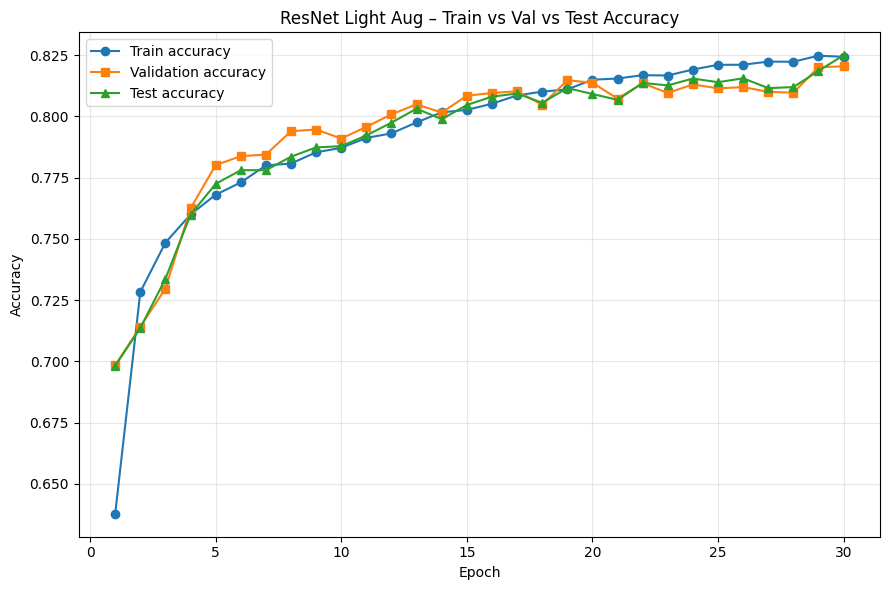

In [ ]:
# Graph Resnet Accuracy vs epoch
epochs_axis = np.arange(1, len(train_acc_res) + 1)

plt.figure(figsize=(9, 6))
plt.plot(epochs_axis, train_acc_res, marker="o", label="Train accuracy")
plt.plot(epochs_axis, val_acc_res, marker="s", label="Validation accuracy")
plt.plot(epochs_axis, test_acc_res, marker="^", label="Test accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet Light Aug – Train vs Val vs Test Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

No sign of overfitting for Resnet

In [ ]:
# Train heavy Aug Resnet
tf.random.set_seed(0)
X_train_aug2 = fix_scale(reshape(X_train_aug2))
X_val_aug2 = fix_scale(reshape(X_val_aug2))
X_test_aug2 = fix_scale(reshape(X_test_aug2))
y_train_aug2 = np.asarray(y_train_aug2).astype(np.int64).ravel()
y_val_aug2 = np.asarray(y_val_aug2).astype(np.int64).ravel()
y_test_aug2 = np.asarray(y_test_aug2).astype(np.int64).ravel()

X_train_res2 = prep_resnet_inputs(X_train_aug2, size=32)
X_val_res2 = prep_resnet_inputs(X_val_aug2, size=32)
X_test_res2 = prep_resnet_inputs(X_test_aug2, size=32)
y_train_res2 = y_train_aug2.astype(np.int64).ravel()
y_val_res2 = y_val_aug2.astype(np.int64).ravel()
y_test_res2 = y_test_aug2.astype(np.int64).ravel()
print(X_train_res.shape, X_val_res.shape, X_test_res.shape)

final_resnet2 = build_resnet(lr=0.001,num_fc_layers=2,fc_width=256)
train_acc_res2 = []
val_acc_res2 = []
test_acc_res2 = []
t0 = time.time()
max_epochs = 30
for epoch in range(max_epochs):
    print(f"Epoch {epoch+1}/{max_epochs}")
    history = final_resnet2.fit(
        X_train_res2, y_train_res2,
        validation_data=(X_val_res2, y_val_res2),
        epochs=1,
        batch_size=128,
        verbose=0,
        shuffle=True,
    )
    train_acc = history.history["accuracy"][0]
    val_acc = history.history["val_accuracy"][0]
    train_acc_res2.append(train_acc)
    val_acc_res2.append(val_acc)
    test_loss, test_acc = final_resnet.evaluate(X_test_res2, y_test_res2, verbose=0)
    test_acc_res2.append(test_acc)
    print(f" train_acc={train_acc:.4f} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f}")

total_secs_resnet2 = time.time() - t0

(50000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
Epoch 1/30
 train_acc=0.6246 | val_acc=0.6930 | test_acc=0.8249
Epoch 2/30
 train_acc=0.7282 | val_acc=0.7216 | test_acc=0.8249
Epoch 3/30
 train_acc=0.7492 | val_acc=0.7362 | test_acc=0.8249
Epoch 4/30
 train_acc=0.7607 | val_acc=0.7290 | test_acc=0.8249
Epoch 5/30
 train_acc=0.7675 | val_acc=0.7381 | test_acc=0.8249
Epoch 6/30
 train_acc=0.7734 | val_acc=0.7349 | test_acc=0.8249
Epoch 7/30
 train_acc=0.7772 | val_acc=0.7372 | test_acc=0.8249
Epoch 8/30
 train_acc=0.7815 | val_acc=0.7560 | test_acc=0.8249
Epoch 9/30
 train_acc=0.7860 | val_acc=0.7532 | test_acc=0.8249
Epoch 10/30
 train_acc=0.7899 | val_acc=0.7640 | test_acc=0.8249
Epoch 11/30
 train_acc=0.7942 | val_acc=0.7636 | test_acc=0.8249
Epoch 12/30
 train_acc=0.7964 | val_acc=0.7697 | test_acc=0.8249
Epoch 13/30
 train_acc=0.8002 | val_acc=0.7768 | test_acc=0.8249
Epoch 14/30
 train_acc=0.8023 | val_acc=0.7704 | test_acc=0.8249
Epoch 15/30
 train_acc=0.8041 | val_acc=0.

In [ ]:
final_test_acc_resnet2 = test_acc_res2[-1]
print("\n--- Final ResNet results Heavy Aug---")
print(f"Final test accuracy: {final_test_acc_resnet2:.4f}")
print(f"Total training time: {total_secs_resnet2:.2f} seconds (~{total_secs_resnet2/60:.2f} min)")


--- Final ResNet results Heavy Aug---
Final test accuracy: 0.8249
Total training time: 331.34 seconds (~5.52 min)


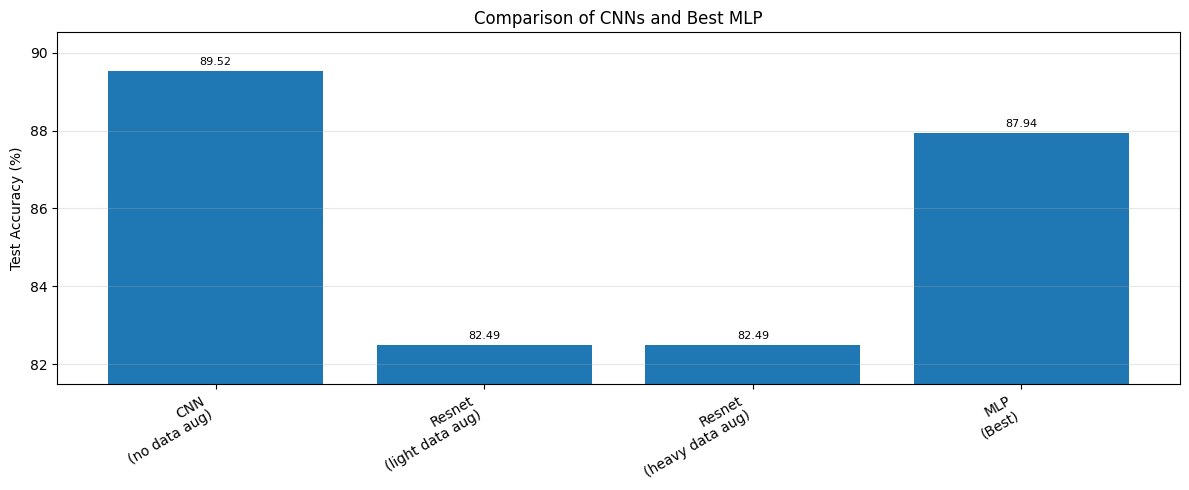

In [ ]:
# Final plot comparing all Resnet with CNN and MLP
names = ["CNN\n(no data aug)","Resnet\n(light data aug)","Resnet\n(heavy data aug)","MLP\n(Best)",]
accs = [test_acc_cnn, final_test_acc_resnet,final_test_acc_resnet2,test_acc_bestl2,]
accs_pct = [a * 100 for a in accs]
x = np.arange(len(names))
plt.figure(figsize=(12, 5))
bars = plt.bar(x, accs_pct)
plt.xticks(x, names, rotation=30, ha="right")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Resnet and Best MLP")
plt.ylim(min(accs_pct) - 1, max(accs_pct) + 1)
plt.grid(axis="y", alpha=0.3)
for bar, acc in zip(bars, accs_pct):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.1,
             f"{acc:.2f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()